# H2Know Modeling - XGBoost Models

Data split:
- Train: 2005 - 2019
- Test: 2020-2021

Notebook Contents:
- XGBoost Hyperparameter Grid Search
- XGBoost Final Model
- XGBoost Final Model Evaluation

## II. NB Setup

In [1]:
# Install modules
%%capture
!pip install category-encoders

In [2]:
# Import modules

# General
# from google.colab import files
# from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import timeit
import datetime as dt
import io

# ML
import sklearn as sk
from sklearn import model_selection
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss, matthews_corrcoef, recall_score, precision_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import category_encoders as ce

In [3]:
# Set up Google Drive
# drive.mount("/content/gdrive")

# Run below if above command giving some trouble
# drive.mount("/content/drive", force_remount=True)

Mounted at /content/gdrive


In [4]:
# Read in Data
# FILE_PATH = '/content/gdrive/My Drive/Capstone_Sum23/03_Data/'

df_raw = pd.read_csv('data/clean_final_full_dataset_v2.csv', low_memory=False)

## III. Quick Data Info.

In [ ]:
df_raw.head()

,Unnamed: 0,row_id,#wpdx_id,#lat_deg,#lon_deg,#facility_type,#clean_country_name,#clean_country_id,#clean_adm1,#clean_adm2,...,Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Rule of Law: Estimate,Voice and Accountability: Estimate,region2_key,log_gni_cap_1000usd_2011ppp,hdi,perc_emp_women_agric,perc_emp_men_agric,avg_yrs_school_female
0,0,71905,6FV7V3JC+222,7.880000,5.070000,Improved,Nigeria,NGA,Ekiti,Ijero,...,-2.101823,-0.864204,-0.903243,-0.430503,Nigeria_Ekiti_2018,8.512,0.610,0,33.7,8.433
1,1,71934,6FV7M9CR+222,7.670000,5.390000,Improved,Nigeria,NGA,Ekiti,Irepodun/Ifelodun,...,-2.101823,-0.864204,-0.903243,-0.430503,Nigeria_Ekiti_2018,8.512,0.610,0,33.7,8.433
2,2,671815,6FRFQ2GV+MQW,6.776732,9.044447,Improved,Nigeria,NGA,Benue,Vande Ikya,...,-1.925443,-0.866751,-0.967467,-0.372614,Nigeria_Benue_2015,8.291,0.554,41.1,64.1,4.749
3,3,396372,6FQ9V98F+PCJ,5.866844,7.373515,Improved,Nigeria,NGA,Imo,Okigwe,...,-1.925443,-0.866751,-0.967467,-0.372614,Nigeria_Imo_2015,8.981,0.608,8.34,10.2,8.187
4,4,674097,6FR9WM66+3W7,6.910172,7.662312,Improved,Nigeria,NGA,Benue,Ogbadibo,...,-1.925443,-0.866751,-0.967467,-0.372614,Nigeria_Benue_2015,8.291,0.554,41.1,64.1,4.749


In [ ]:
pd.DataFrame(df_raw.groupby(['#clean_country_name'])['row_id'].count())

,row_id
#clean_country_name,
Nigeria,100549
Sierra Leone,50861
Uganda,108108


In [ ]:
pd.DataFrame(df_raw.groupby(['status_fin'])['row_id'].count())

,row_id
status_fin,
functional,138930
not_functional,120588


## IV. Data Prep

In [5]:
def convert_target(x):
  """
  Convert target variable 'status_fin' to a binary variable
    - 0: non-functional
    - 1: functional

  Args: row value

  Result: 0 or 1
  """
  if x == 'functional':
    x = 1
  else:
    x = 0
  return x

In [6]:
def float_convert(val):
  """
  Convert column values to float values.

  Args: row value

  Result: new float value
  """
  if val == '#DIV/0!':
    val = np.nan
  else:
    val = float(val)
  return val

In [7]:
# Apply column changes
df_raw['status_fin'] = df_raw['status_fin'].apply(lambda x: convert_target(x))
df_raw['perc_emp_men_agric_fin'] = df_raw['perc_emp_men_agric'].apply(lambda x: float_convert(x))
df_raw['perc_emp_women_agric_fin'] = df_raw['perc_emp_women_agric'].apply(lambda x: float_convert(x))

In [8]:
# Drop columns that won't be used
cols_drop = ['Unnamed: 0', '#activity_id', '#clean_country_id', '#status_clean', '#status_id', \
             'country2_key', 'region2_key', 'perc_emp_men_agric', \
             'perc_emp_women_agric']
df = df_raw.drop(columns = cols_drop)
df.shape

(259518, 58)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259518 entries, 0 to 259517
Data columns (total 58 columns):
 #   Column                                                                                          Non-Null Count   Dtype  
---  ------                                                                                          --------------   -----  
 0   row_id                                                                                          259518 non-null  int64  
 1   #wpdx_id                                                                                        259518 non-null  object 
 2   #lat_deg                                                                                        259518 non-null  float64
 3   #lon_deg                                                                                        259518 non-null  float64
 4   #facility_type                                                                                  259518 non-null  object 
 5   #c

### A. Model Timeframe

In [9]:
df = df[df['report_year'] < 2022]
df['report_date'] = pd.to_datetime(df['report_date'])
df = df.sort_values('report_date')
df.shape

<ipython-input-9-117a74288cec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['report_date'] = pd.to_datetime(df['report_date'])


(234195, 58)

### B. Data Split Plan
**FOR CV TESTING**
- 259518 rows
  - **Train:** 2005 - 2019
  - **Test:** 2020 - 2021

- There is some concern that the model may not be able to adjust for pandemic
  - during the pandemic there was less data collection
  - also possible that waterpoints themselves may have become in a worse state

In [ ]:
df_year = pd.DataFrame(df.groupby(['report_year']).size())
df_year.transpose()

report_year,2005,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,669,6,76529,2213,4240,4455,4930,89134,19719,1067,13484,9685,3099,4965,17907,7416


## V. Grid Search
[refer to final model notebook]

## VI. Top XGBoost Model

https://www.youtube.com/watch?v=z3ZnOW-S550&ab_channel=RobMulla

https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook

https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it

https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

### A. Data Split

In [10]:
# Perform data split for both with and w/o secondary data

# Columns to drop
cols_drop2 = ['status_fin', 'report_date', 'row_id', '#wpdx_id']
secondary_cols_drop = ['Access to electricity (% of population)','Agricultural land (% of land area)', \
                       'Agriculture, forestry, and fishing, value added (% of GDP)', \
                       'Annual freshwater withdrawals, total (% of internal resources)', \
                       'Cooling Degree Days', 'GDP growth (annual %)', \
                       'Government Effectiveness: Estimate', 'Heat Index 35', \
                       'Heating Degree Days', 'Land Surface Temperature', \
                       'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources', \
                       'Political Stability and Absence of Violence/Terrorism: Estimate', \
                       'Regulatory Quality: Estimate', 'Rule of Law: Estimate', \
                       'Voice and Accountability: Estimate', 'log_gni_cap_1000usd_2011ppp', \
                       'hdi', 'avg_yrs_school_female', 'perc_emp_men_agric_fin', \
                       'perc_emp_women_agric_fin']

# Train: 2005-2019
train_features_id = df[df['report_year'] < 2020]
train_features = df[df['report_year'] < 2020].drop(columns=cols_drop2)
train_features_wpdx = train_features.drop(columns = secondary_cols_drop)
train_labels = df[df['report_year'] < 2020]['status_fin']

# Test: 2020-2021
test_features_id = df[(df['report_year'] >= 2020)]
test_features = df[(df['report_year'] >= 2020)].drop(columns=cols_drop2)
test_features_wpdx = test_features.drop(columns = secondary_cols_drop)
test_labels = df[(df['report_year'] >= 2020)]['status_fin']

# Binary Encoding
cat_cols = list(train_features.select_dtypes(exclude=('int64', 'float64')).columns)
cat_cols_wpdx = list(train_features_wpdx.select_dtypes(exclude=('int64', 'float64')).columns)
binary_encoder = ce.BinaryEncoder(cols = cat_cols, return_df = True)
binary_encoder_wpdx = ce.BinaryEncoder(cols = cat_cols_wpdx, return_df = True)

# Split to categorical features & rejoin with rest of dataset
train_features_cat = train_features.select_dtypes(exclude=('int64', 'float64'))
train_features_cat = binary_encoder.fit_transform(train_features_cat)
train_features = pd.concat([train_features.select_dtypes(exclude=('object', 'bool', 'datetime')), train_features_cat], axis=1)

train_features_cat_wpdx = train_features_wpdx.select_dtypes(exclude=('int64', 'float64'))
train_features_cat_wpdx = binary_encoder_wpdx.fit_transform(train_features_cat_wpdx)
train_features_wpdx = pd.concat([train_features_wpdx.select_dtypes(exclude=('object', 'bool', 'datetime')), train_features_cat_wpdx], axis=1)

test_features_cat = test_features.select_dtypes(exclude=('int64', 'float64'))
test_features_cat = binary_encoder.transform(test_features_cat)
test_features = pd.concat([test_features.select_dtypes(exclude=('object', 'bool', 'datetime')), test_features_cat], axis=1)

test_features_cat_wpdx = test_features_wpdx.select_dtypes(exclude=('int64', 'float64'))
test_features_cat_wpdx = binary_encoder_wpdx.transform(test_features_cat_wpdx)
test_features_wpdx = pd.concat([test_features_wpdx.select_dtypes(exclude=('object', 'bool', 'datetime')), test_features_cat_wpdx], axis=1)

print('Train features shape:', train_features.shape)
print('Train features shape:', train_features_wpdx.shape)
print('Train labels shape:', train_labels.shape)
print()
print()
print('Test features shape:', test_features.shape)
print('Test features shape:', test_features_wpdx.shape)
print('Test labels shape:', test_labels.shape)

Train features shape: (226131, 139)
Train features shape: (226131, 119)
Train labels shape: (226131,)


Test features shape: (8064, 139)
Test features shape: (8064, 119)
Test labels shape: (8064,)


### B. Execute CV

In [12]:
tss = TimeSeriesSplit(n_splits=5)

fold = 0
preds_train_list = []
preds_val_list = []
scores_train_list = []
scores_val_list = []

for cv_train_idx, cv_val_idx in tss.split(train_features):
  fold += 1
  fold_train_features = train_features.iloc[cv_train_idx]
  fold_train_labels = train_labels.iloc[cv_train_idx]
  fold_val_features = train_features.iloc[cv_val_idx]
  fold_val_labels = train_labels.iloc[cv_val_idx]

  # Top model from grid search
  xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic',
                                     seed = 1,
                                     max_depth = 5,
                                     min_child_weight = 1,
                                     gamma = 0,
                                     subsample = 0.9,
                                     colsample_bytree = 0.7,
                                     n_estimators = 85,
                                     )


  eval_set = [(fold_train_features, fold_train_labels), (fold_val_features, fold_val_labels)]

  xgb_classifier.fit(fold_train_features,
                     fold_train_labels,
                     eval_set=eval_set,
                     verbose=True)

  # Predict the labels of the train set
  preds_train = xgb_classifier.predict(fold_train_features)
  preds_prob_train = xgb_classifier.predict_proba(fold_train_features)[:,1]

  preds_train_list.append([preds_train, preds_prob_train])

  # Predict the labels of the val set
  preds_val = xgb_classifier.predict(fold_val_features)
  preds_prob_val = xgb_classifier.predict_proba(fold_val_features)[:,1]

  preds_val_list.append([preds_val, preds_prob_val])

  # Get training metrics
  accuracy_train = accuracy_score(fold_train_labels, preds_train)
  precision_train = precision_score(fold_train_labels, preds_train)
  recall_train = recall_score(fold_train_labels, preds_train)
  f1_score_train = f1_score(fold_train_labels, preds_train)
  mcc_train = matthews_corrcoef(fold_train_labels, preds_train)
  auc_roc_train = roc_auc_score(fold_train_labels, xgb_classifier.predict_proba(fold_train_features)[:,1])

  train_eval_dict = {'accuracy_train':accuracy_train,
                     'precision_train': precision_train,
                     'recall_train': recall_train,
                     'f1_score_train': f1_score_train,
                     'mcc_train': mcc_train,
                     'auc_roc_train': auc_roc_train}

  scores_train_list.append(train_eval_dict)

  # Get validation metrics
  accuracy_val = accuracy_score(fold_val_labels, preds_val)
  precision_val = precision_score(fold_val_labels, preds_val)
  recall_val = recall_score(fold_val_labels, preds_val)
  f1_score_val = f1_score(fold_val_labels, preds_val)
  mcc_val = matthews_corrcoef(fold_val_labels, preds_val)
  auc_roc_val = roc_auc_score(fold_val_labels, xgb_classifier.predict_proba(fold_val_features)[:,1])

  val_eval_dict = {'accuracy_val': accuracy_val,
                    'precision_val': precision_val,
                    'recall_val': recall_val,
                    'f1_score_val': f1_score_val,
                    'mcc_val': mcc_val,
                    'auc_roc_val': auc_roc_val}

  scores_val_list.append(val_eval_dict)


[0]	validation_0-logloss:0.45346	validation_1-logloss:0.46366
[1]	validation_0-logloss:0.32151	validation_1-logloss:0.33924
[2]	validation_0-logloss:0.23940	validation_1-logloss:0.26395
[3]	validation_0-logloss:0.18520	validation_1-logloss:0.21498
[4]	validation_0-logloss:0.15051	validation_1-logloss:0.19851
[5]	validation_0-logloss:0.13658	validation_1-logloss:0.18446
[6]	validation_0-logloss:0.11693	validation_1-logloss:0.17342
[7]	validation_0-logloss:0.10031	validation_1-logloss:0.15479
[8]	validation_0-logloss:0.09047	validation_1-logloss:0.14632
[9]	validation_0-logloss:0.08577	validation_1-logloss:0.14199
[10]	validation_0-logloss:0.07814	validation_1-logloss:0.13524
[11]	validation_0-logloss:0.07271	validation_1-logloss:0.13123
[12]	validation_0-logloss:0.07023	validation_1-logloss:0.13066
[13]	validation_0-logloss:0.06714	validation_1-logloss:0.12528
[14]	validation_0-logloss:0.06607	validation_1-logloss:0.12395
[15]	validation_0-logloss:0.06330	validation_1-logloss:0.12292
[1

In [13]:
xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=85, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [14]:
# FILE_PATH2 = '/content/gdrive/My Drive/Capstone_Sum23/04_Code/05_SavedModels/'
xgb_classifier.save_model('models/xgb_temporal_all_2021_Test2020.json')

### C. Evaluate CV

In [15]:
def get_avg_scores(eval_list, scores_list):
  result_list = []
  for metric in eval_list:
    metric_result = [f'Average {metric} score:', np.mean([score[metric] for score in scores_list])]
    result_list.append(metric_result)
  return result_list

In [16]:
eval_train_metrics = ['accuracy_train', 'precision_train', 'recall_train', 'f1_score_train', 'mcc_train', 'auc_roc_train']
eval_val_metrics = ['accuracy_val', 'precision_val', 'recall_val', 'f1_score_val', 'mcc_val', 'auc_roc_val']

results_train_cv = get_avg_scores(eval_train_metrics, scores_train_list)
results_val_cv = get_avg_scores(eval_val_metrics, scores_val_list)

In [17]:
print('Training - CV')
results_train_cv

Training - CV


[['Average accuracy_train score:', 0.9890078392487561],
 ['Average precision_train score:', 0.9865770591336359],
 ['Average recall_train score:', 0.9981391450492352],
 ['Average f1_score_train score:', 0.9923238268049079],
 ['Average mcc_train score:', 0.9723578061739383],
 ['Average auc_roc_train score:', 0.9982255401253702]]

In [18]:
print('Validation - CV')
results_val_cv

Validation - CV


[['Average accuracy_val score:', 0.8559329229462959],
 ['Average precision_val score:', 0.8206183106577057],
 ['Average recall_val score:', 0.9415586353601206],
 ['Average f1_score_val score:', 0.8591963049453339],
 ['Average mcc_val score:', 0.7419009008768607],
 ['Average auc_roc_val score:', 0.899689648850506]]

### D. Test

In [19]:
xgb_classifier = xgb.XGBClassifier()
# FILE_PATH2 = '/content/gdrive/My Drive/Capstone_Sum23/04_Code/05_SavedModels/'
xgb_classifier.load_model('models/xgb_temporal_all_2021_Test2020.json')

In [20]:
eval_set = [(train_features, train_labels), (test_features, test_labels)]

xgb_classifier.fit(train_features,
                  train_labels,
                  eval_metric=["error", "logloss"],
                  eval_set=eval_set,
                  verbose=True)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-error:0.03593	validation_0-logloss:0.46901	validation_1-error:0.70089	validation_1-logloss:0.75655
[1]	validation_0-error:0.02471	validation_0-logloss:0.33751	validation_1-error:0.67063	validation_1-logloss:0.77055
[2]	validation_0-error:0.02422	validation_0-logloss:0.25482	validation_1-error:0.64472	validation_1-logloss:0.69599
[3]	validation_0-error:0.02359	validation_0-logloss:0.22973	validation_1-error:0.40427	validation_1-logloss:0.67702
[4]	validation_0-error:0.02335	validation_0-logloss:0.18477	validation_1-error:0.42956	validation_1-logloss:0.63952
[5]	validation_0-error:0.02184	validation_0-logloss:0.15289	validation_1-error:0.42312	validation_1-logloss:0.63666
[6]	validation_0-error:0.02164	validation_0-logloss:0.13109	validation_1-error:0.27877	validation_1-logloss:0.59406
[7]	validation_0-error:0.02156	validation_0-logloss:0.11466	validation_1-error:0.27989	validation_1-logloss:0.59547
[8]	validation_0-error:0.02091	validation_0-logloss:0.10949	validation_1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              feature_types=['float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'float',
                             'float', 'float', 'float', 'float', 'int', 'int',
                             'int', 'float', 'int...
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=85, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
# Predict the labels of the test set
preds_test = xgb_classifier.predict(test_features)
preds_prob_test = xgb_classifier.predict_proba(test_features)[:,1]

### E. Model Evaluation

In [22]:
# Get testing metrics
accuracy_test = accuracy_score(test_labels, preds_test)
precision_result = precision_score(test_labels, preds_test)
recall_result = recall_score(test_labels, preds_test)
f1_score_result = f1_score(test_labels, preds_test)
mcc_result = matthews_corrcoef(test_labels, preds_test)
auc_roc_result = roc_auc_score(test_labels, xgb_classifier.predict_proba(test_features)[:,1])

print('TESTING METRICS')
print(f'test accuracy: {accuracy_test: .2%}')
print(f"Precision: {precision_result: .2%}")
print(f"Recall: {recall_result: .2%}")
print(f"F-1 Score: {f1_score_result: .2%}")
print(f"Matthews correlation coefficient: {mcc_result: .2%}")
print(f"AUC/ROC: {auc_roc_result: .2%}")

TESTING METRICS
test accuracy:  78.70%
Precision:  82.18%
Recall:  21.25%
F-1 Score:  33.77%
Matthews correlation coefficient:  34.53%
AUC/ROC:  83.58%


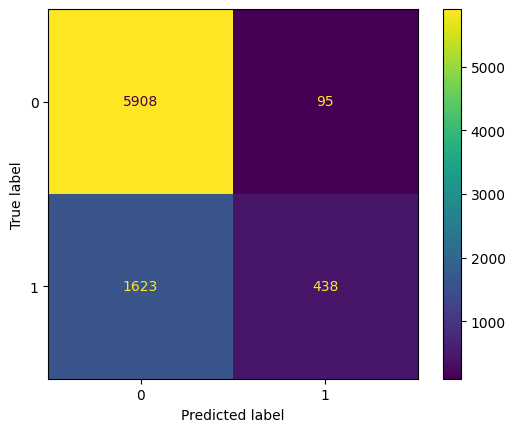

In [23]:
cm = confusion_matrix(test_labels, preds_test, labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [24]:
test_results = np.vstack((test_labels, preds_test)).T
test_results = pd.DataFrame(data= test_results, columns=['label', 'pred'])
df_test = pd.concat([test_features_id.reset_index(), test_results], axis=1)
df_test.shape

(8064, 61)

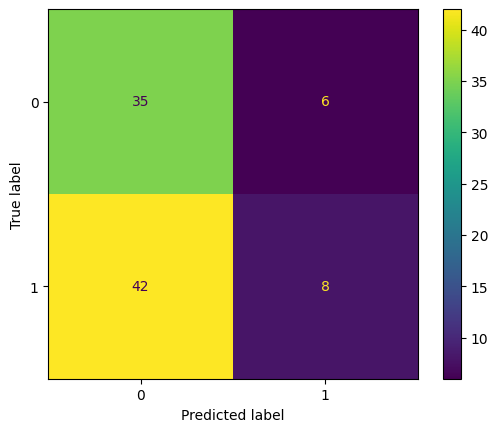

In [25]:
df_test_N = df_test[df_test['#clean_country_name'] == 'Nigeria']
cm = confusion_matrix(df_test_N['label'], df_test_N['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [34]:
print('Nigeria')
print()
print('majority class')
print('accuracy', (35+8)/(35+8+6+42))
precision = (8)/(8+6)
print('precision', precision)
recall = (8)/(8+42)
print('recall', recall)
print('f1-score', 2*((precision*recall)/(precision+recall)))

Nigeria

majority class
accuracy 0.4725274725274725
precision 0.5714285714285714
recall 0.16
f1-score 0.25


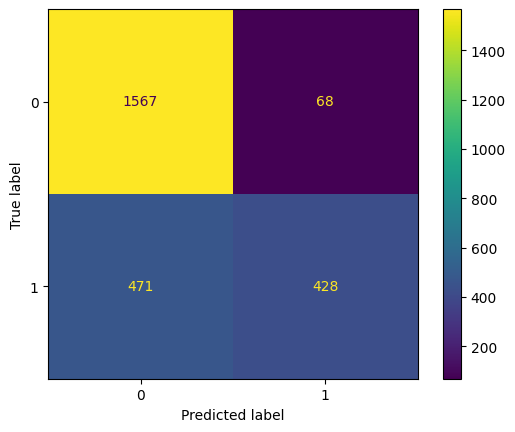

In [27]:
df_test_U = df_test[df_test['#clean_country_name'] == 'Uganda']
cm = confusion_matrix(df_test_U['label'], df_test_U['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [35]:
print('Uganda')
print()
print('majority class')
print('accuracy', (1567+428)/(1567+428+68+471))
precision = (428)/(428+68)
print('precision', precision)
recall = (428)/(428+471)
print('recall', recall)
print('f1-score', 2*((precision*recall)/(precision+recall)))

Uganda

majority class
accuracy 0.787292817679558
precision 0.8629032258064516
recall 0.4760845383759733
f1-score 0.6136200716845879


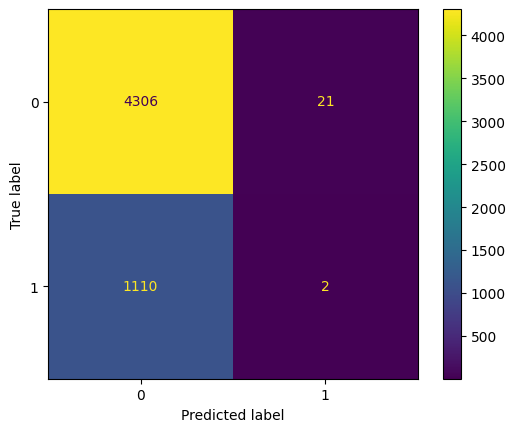

In [29]:
df_test_SL = df_test[df_test['#clean_country_name'] == 'Sierra Leone']
cm = confusion_matrix(df_test_SL['label'], df_test_SL['pred'], labels=xgb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
display_labels=xgb_classifier.classes_)
disp.plot()
plt.show()

In [36]:
print('Sierra Leone')
print()
print('majority class')
print('accuracy', (4306+2)/(4306+2+1110+21))
precision = (2)/(21+2)
print('precision', precision)
recall = (2)/(2+1110)
print('recall', recall)
print('f1-score', 2*((precision*recall)/(precision+recall)))

Sierra Leone

majority class
accuracy 0.7920573634859349
precision 0.08695652173913043
recall 0.0017985611510791368
f1-score 0.003524229074889868


In [31]:
results = xgb_classifier.evals_result()

Remember to change the range to be the number of estimators in the model

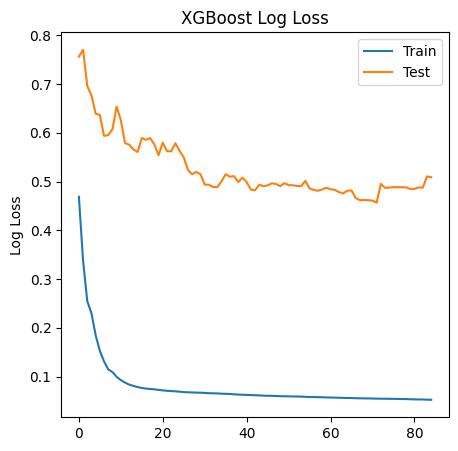

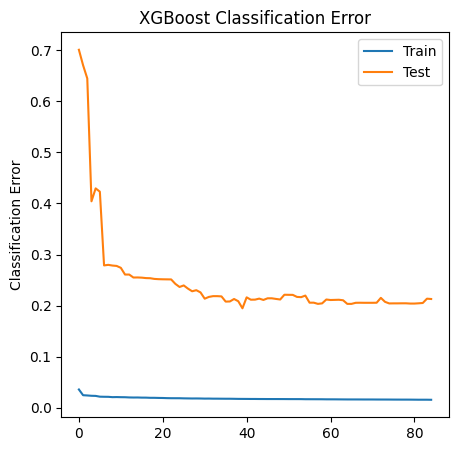

In [32]:
from xgboost.plotting import plot_tree
# plot log loss
x_axis = range(0, 85)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Log Loss")
plt.title("XGBoost Log Loss")
plt.show()

# plot classification error
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

Features Importance

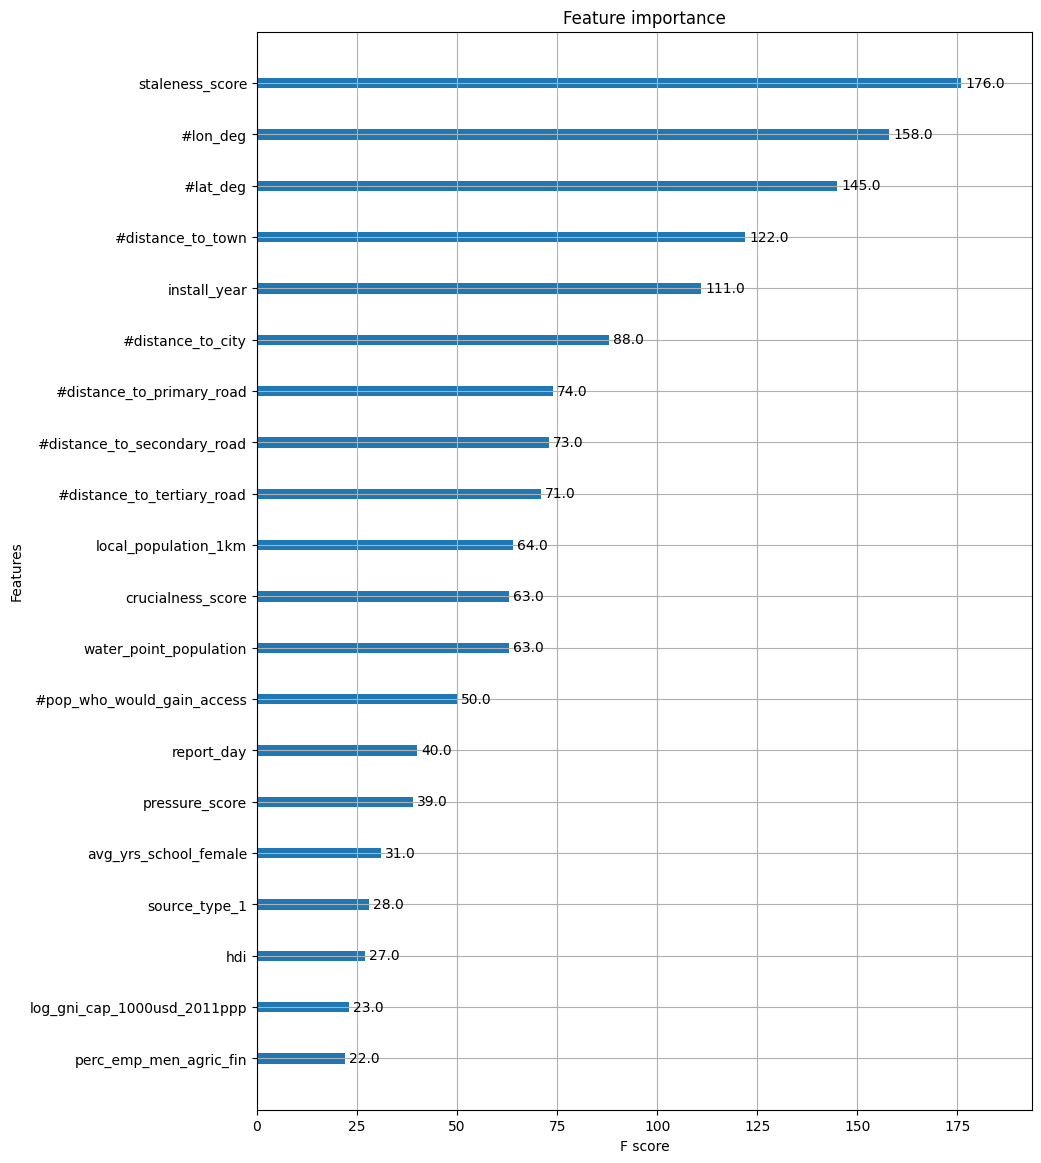

In [33]:
# Review the important features
def plot_features(booster, figsize, max_num_features=20):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return xgb.plot_importance(booster=booster, ax=ax, max_num_features=max_num_features)
plot_features(xgb_classifier, (10,14))
plt.show()